## Notebook to analyze single PLQY readings.  
See other example for implied JV curve analysis  
Need reference files named PowerCurrent_Averaged.csv, SQ.csv, Detector_Responsivity.csv

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm
import seaborn as sns
plus_minus = u"\u00B1"

Define functions for analyis:

In [2]:
def load_plqy(fid):

    """Simple function to load .csv plqy data

    Args:
        fid (str): file path, should be .csv

    Returns:
        pd.DataFrame: a data frame containing the six scan types necessary to calculate PLQY
    """

    df = pd.read_csv(fid)
    
    return df
    
def calc_plqy_deMello(data: pd.DataFrame, sample_wl: float, sample_resp: float, laser_wl: float, laser_resp: float):

    """A function to calculate the PLQY based in a publication by de Mello et al.
       The most widely used method for calculating PLQY.
       https://doi.org/10.1002/adma.19970090308

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
        sample_wl (float): the peak emission wavelength of the sample
        sample_resp (float): the responsivity of the detector at sample_wl
        laser_wl (float): the emission wavelength of the laser. Probably 532.0nm
        laser_resp (float): the responsivity of the detector at the laser_wl

    Returns:
        tuple: (PLQY, PLQY error), resported as fractional, not percentage
    """

    E_in = data['in_lp'].mean()
    E_in_err = data['in_lp'].std()/E_in

    E_out = data['out_lp'].mean()
    E_out_err = data['out_lp'].std()/E_out

    X_in = data['in_nolp'].mean() - E_in
    X_in_err = (data['in_nolp'].std()/X_in) + E_in_err

    X_out = data['out_nolp'].mean() - E_out
    X_out_err = (data['out_nolp'].std()/X_out) + E_out_err

    X_empty = data['empty_nolp'].mean() - data['empty_lp'].mean()
    X_empty_err = (data['empty_nolp'].std()/data['empty_nolp'].mean()) + (data['empty_lp'].std()/data['empty_lp'].mean())

    E_in = E_in*(sample_wl/sample_resp)
    E_out = E_out*(sample_wl/sample_resp)

    X_in = X_in*(laser_wl/laser_resp)
    X_out = X_out*(laser_wl/laser_resp)
    X_empty = X_empty*(laser_wl/laser_resp)

    a = (X_out-X_in)/X_out
    a_err = np.sqrt(((X_out_err + X_in_err)**2) + (X_out_err**2))

    plqy = (E_in-(1-a)*E_out)/(X_empty*a)
    plqy_err = np.sqrt((E_in_err**2) + ((E_out_err + a_err)**2) + (X_empty_err**2))

    return plqy, plqy_err*plqy


def get_responsivity(emission_wl):
    """internal function to get the respnsivity of the detector at the emission wavelength

    Args:
        emission_wl (float): the mean emission wavelength of the sample

    Returns:
        float: the responsivity, arbitrary units
    """
    try:
        resp = pd.read_csv('Detector_Responsivity.csv')
        return float(resp['Responsivity'][resp['Wavelength'] == emission_wl])

    except: # if not, tell the user to do so
        print(f'Detector_Responsivity.csv not able to load...check code')

Load in data  

In [3]:
# load in sample names from the folder names in the directory
path = os.getcwd()
sample_names = natsorted([n for n in os.listdir() if '.' not in n])

# load in the power reference and index by the currents rounded to the first decimal place
ref = pd.read_csv('PowerCurrent_Averaged.csv', index_col='currents')
ref.index = np.round(ref.index, decimals = 1)

# load in the SQ limit dataframe
sq = pd.read_csv('SQ.csv', index_col='Eg')

fids = {}
for n in sample_names:
    s_path = os.path.join(path, n)
    fids[n] = natsorted([os.path.join(s_path, f) for f in os.listdir(s_path) if '.csv' in f])

currents = {}
data = {}
for n in sample_names:
    currents[n] = [np.round(float(f.split("_")[-1][:-4]), decimals=1) for f in fids[n]]
    data[n] = {}
    data[n]['powers'] = np.array(ref['power'][currents[n]])*1000 #watts to mW

Modify EMISSION_WL value dependent on bandgap/PL spectra

In [4]:
EMISSION_WL = 808 #nm, modify this based on bandgap
LASER_WL = 532 #nm
LASER_SPOT_SIZE = 0.066 #cm^2, roughly estimated
kT = 0.026 #eV
REFLECTION_LOSSES = 0.08 # fraction of 1 taken off of the Jsc to make implied curve more real
bandgap =  np.round(1240/EMISSION_WL, 3) #ev

EMISSION_RESP = get_responsivity(EMISSION_WL)
LASER_RESP = get_responsivity(LASER_WL)

Calculate PLQY and populate data dictionary dataframes with values

In [5]:
for n in sample_names:
    temp_plqys = []
    temp_errs = []
    
    for fid in tqdm(fids[n]):

        deMello = calc_plqy_deMello(load_plqy(fid), EMISSION_WL, EMISSION_RESP, LASER_WL, LASER_RESP)
        temp_plqys.append(deMello[0])
        temp_errs.append(deMello[1])

 
    data[n]['plqy'] = np.array(temp_plqys)
    data[n]['plqy'][data[n]['plqy'] < 0] = np.nan
    data[n]['plqy_err'] = np.array(temp_errs)
    data[n]['Eg'] = np.round(1240/EMISSION_WL, decimals=2)
    data[n]['Voc_rad'] = sq['Voc'][data[n]['Eg']]
    data[n]['Jsc_rad'] = sq['Jsc'][data[n]['Eg']]
    data[n]['Suns'] = (data[n]['powers']/LASER_SPOT_SIZE)/sq['laser power'][data[n]['Eg']]
    data[n]['qfls'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns']*data[n]['plqy'])
    data[n]['qfls_err'] = kT*np.log(1 + data[n]['plqy_err']/data[n]['plqy'])
    data[n]['qfls_rad'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns'])
    data[n]['implied_current'] = data[n]['Jsc_rad']*(1-REFLECTION_LOSSES)*(1-data[n]['Suns'])
    data[n]['implied_current_limit'] = data[n]['Jsc_rad']*(1-data[n]['Suns'])
   
    

100%|██████████| 1/1 [00:00<00:00, 267.36it/s]


In [12]:
print(sample_names)

['S0', 'S1']


In [6]:
#Modify your directory names (stored in sample_names) to match your sample descriptions 
sample_names_description = {
    'S0': 'FACl_glass',
    'S1': 'MACl_glass'
}

Set your color palette to your preference

In [13]:
colors = sns.set_palette('Set2')

Plot PLQY

In [14]:
def plot_plqy(save=False):
    plt.figure(figsize=(8,6), dpi=600)
    for i, n in enumerate(sample_names):
        y = data[n]['plqy']
        y_err = data[n]['plqy_err']
        plt.bar(x = i, height = y, yerr = y_err, label = sample_names_description[n], capsize = 5, color = colors)

    plt.xticks(ticks = np.arange(len(sample_names)), labels = sample_names_description.values())
    plt.yscale('log')
    plt.ylim(1e-4, 1)
    plt.legend()
    plt.ylabel('PLQY')
    plt.title('PLQY')
    if save: 
        plt.savefig('PLQY.png', dpi=600)

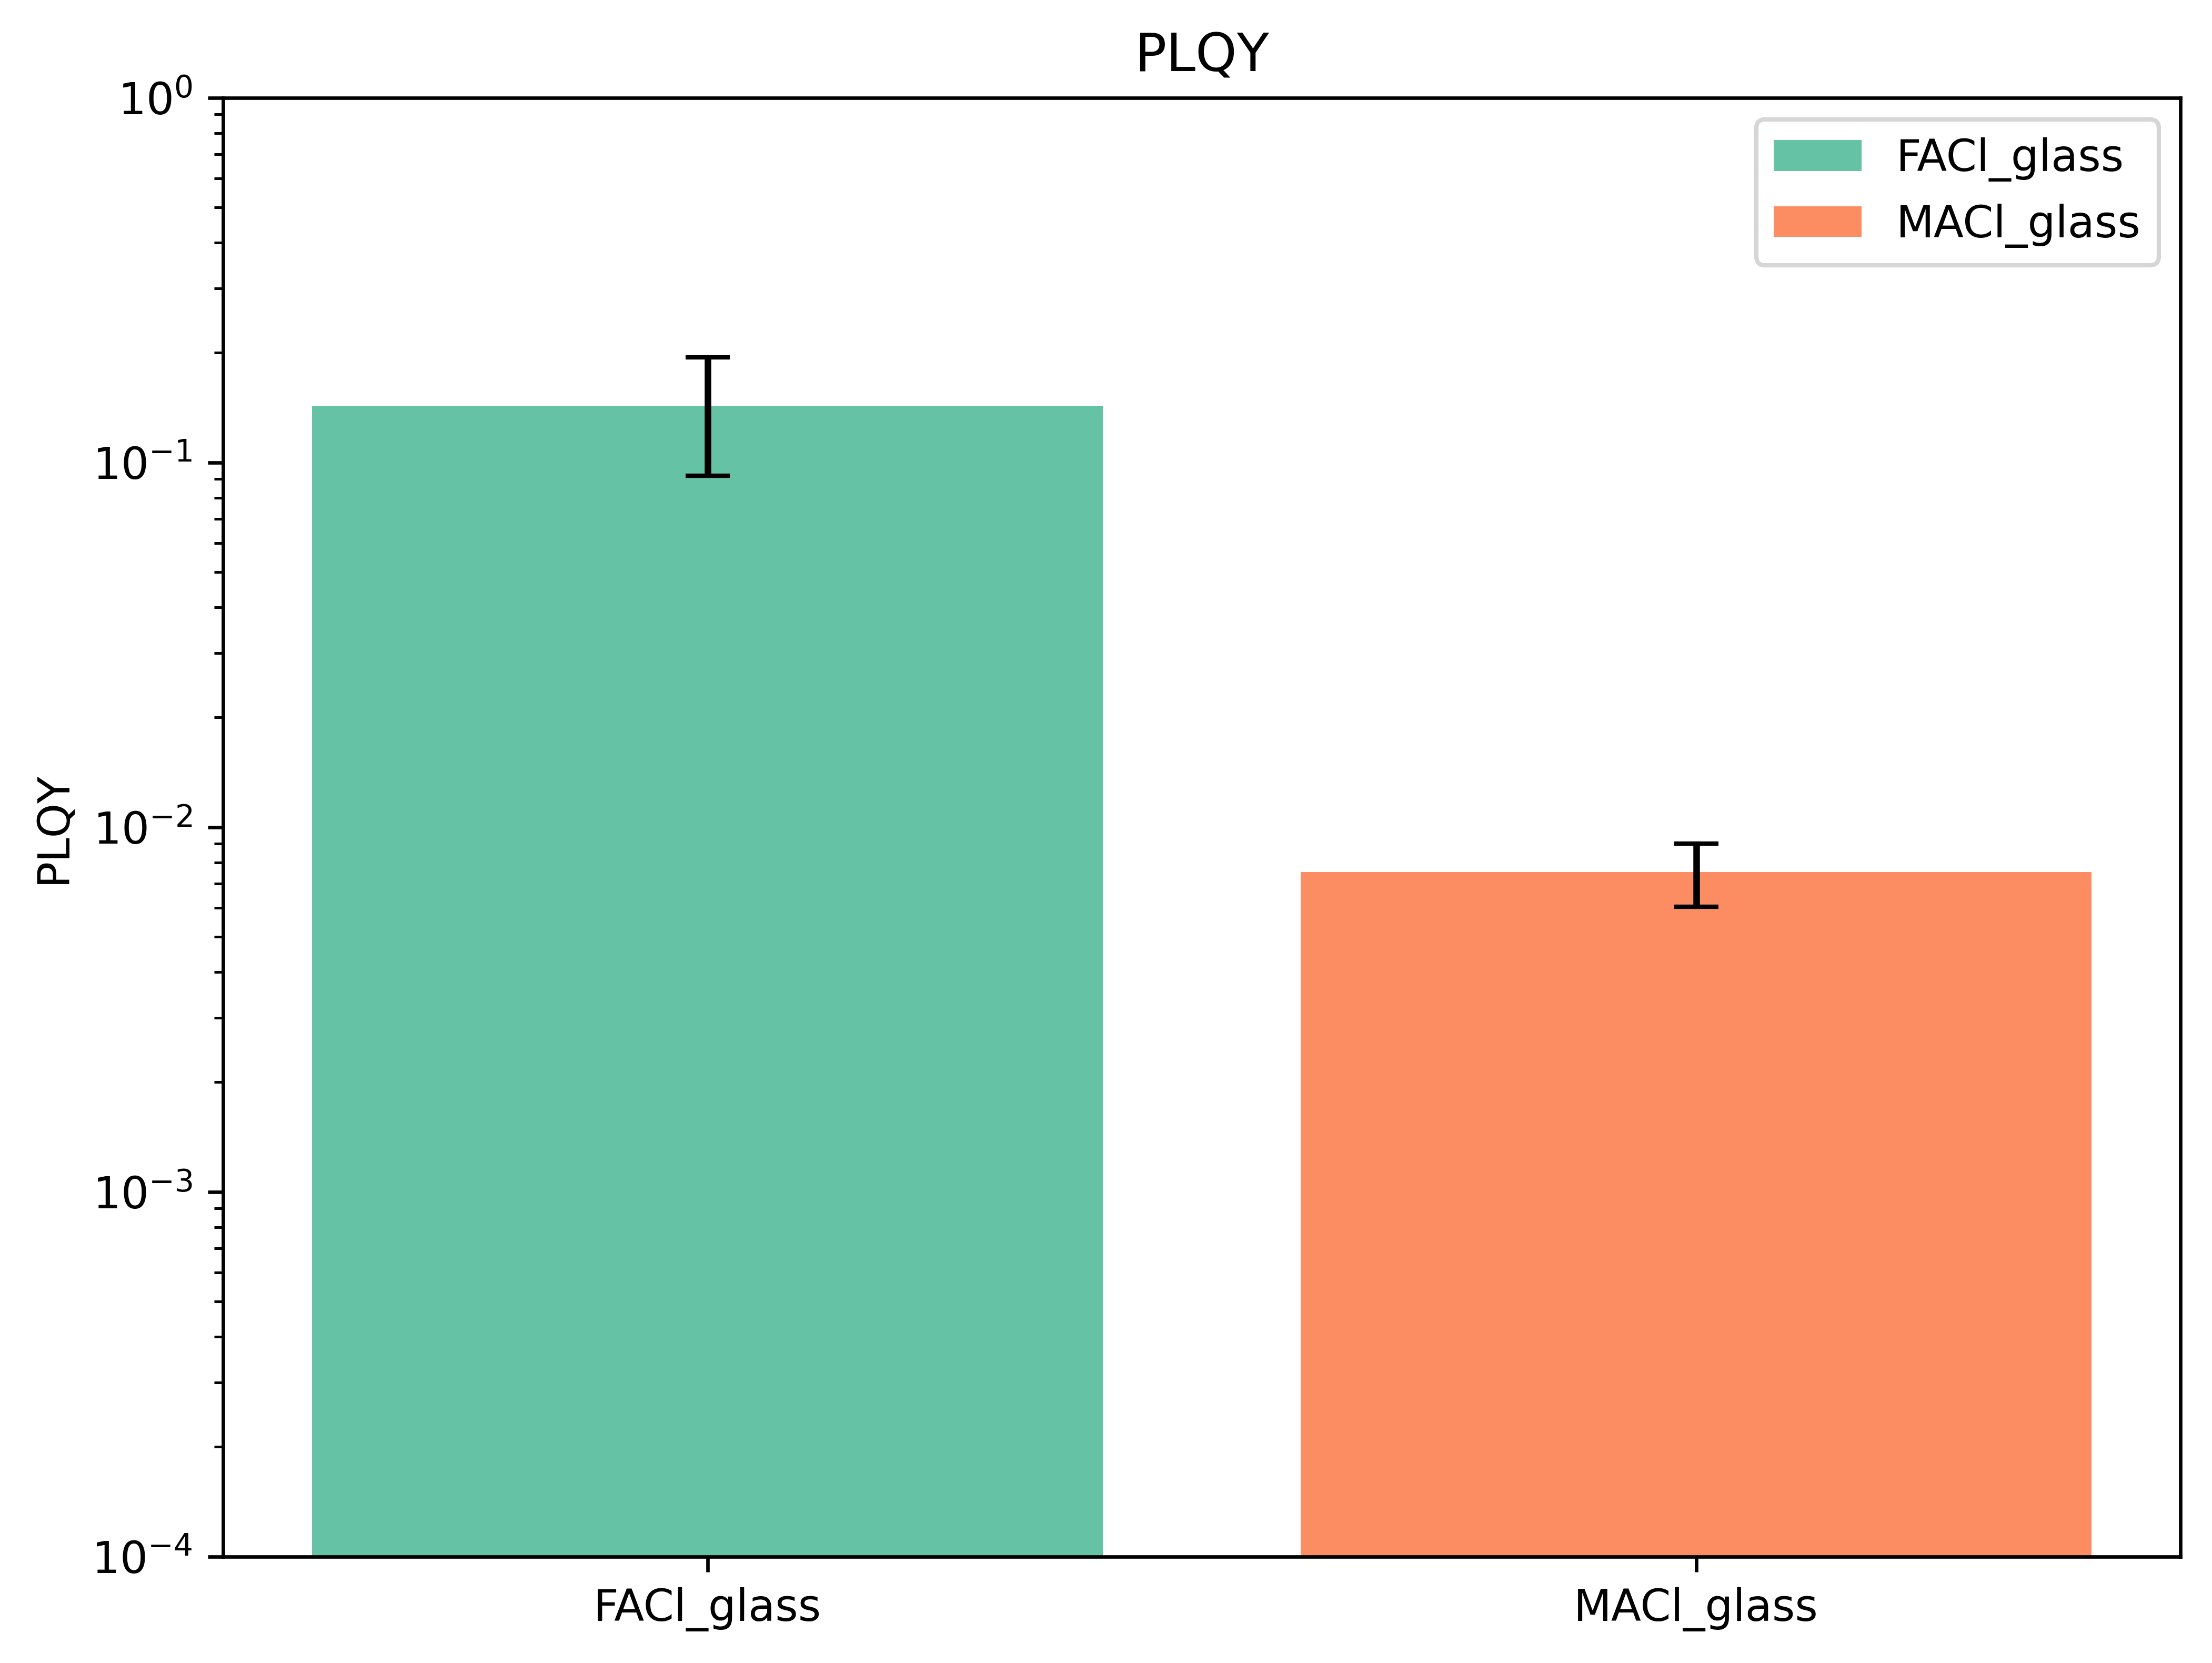

In [15]:
#Call the function, save by setting save=True
plot_plqy(save=True)

Plot QFLS/ Implied Voltage

In [21]:
def plot_qfls(save=False):
    plt.figure(figsize=(8,6), dpi=600)
    #rad_limit = data[n]['qfls_rad']
    #plt.bar(x = 0, height = rad_limit, label = 'SQ Limit', color = 'gray')
    for i, n in enumerate(sample_names):
        rad_limit = data[n]['qfls_rad']
        y = data[n]['qfls']
        y_err = data[n]['qfls_err']
        plt.bar(x = 0, height = rad_limit, label = 'SQ Limit', color = 'gray')
        plt.bar(x = i+1, height = y, yerr = y_err, label = sample_names_description[n], capsize = 5, color = colors)

    plt.xticks(ticks = np.arange(len(sample_names) + 1), labels = ['SQ Limit'] + list(sample_names_description.values()))
    #plt.legend(loc = 'best')
    plt.ylim(0.5, 1.35)
    plt.ylabel('QFLS (V)')
    plt.title('QFLS')
    if save:
        plt.savefig('PLQY.png', dpi=600)

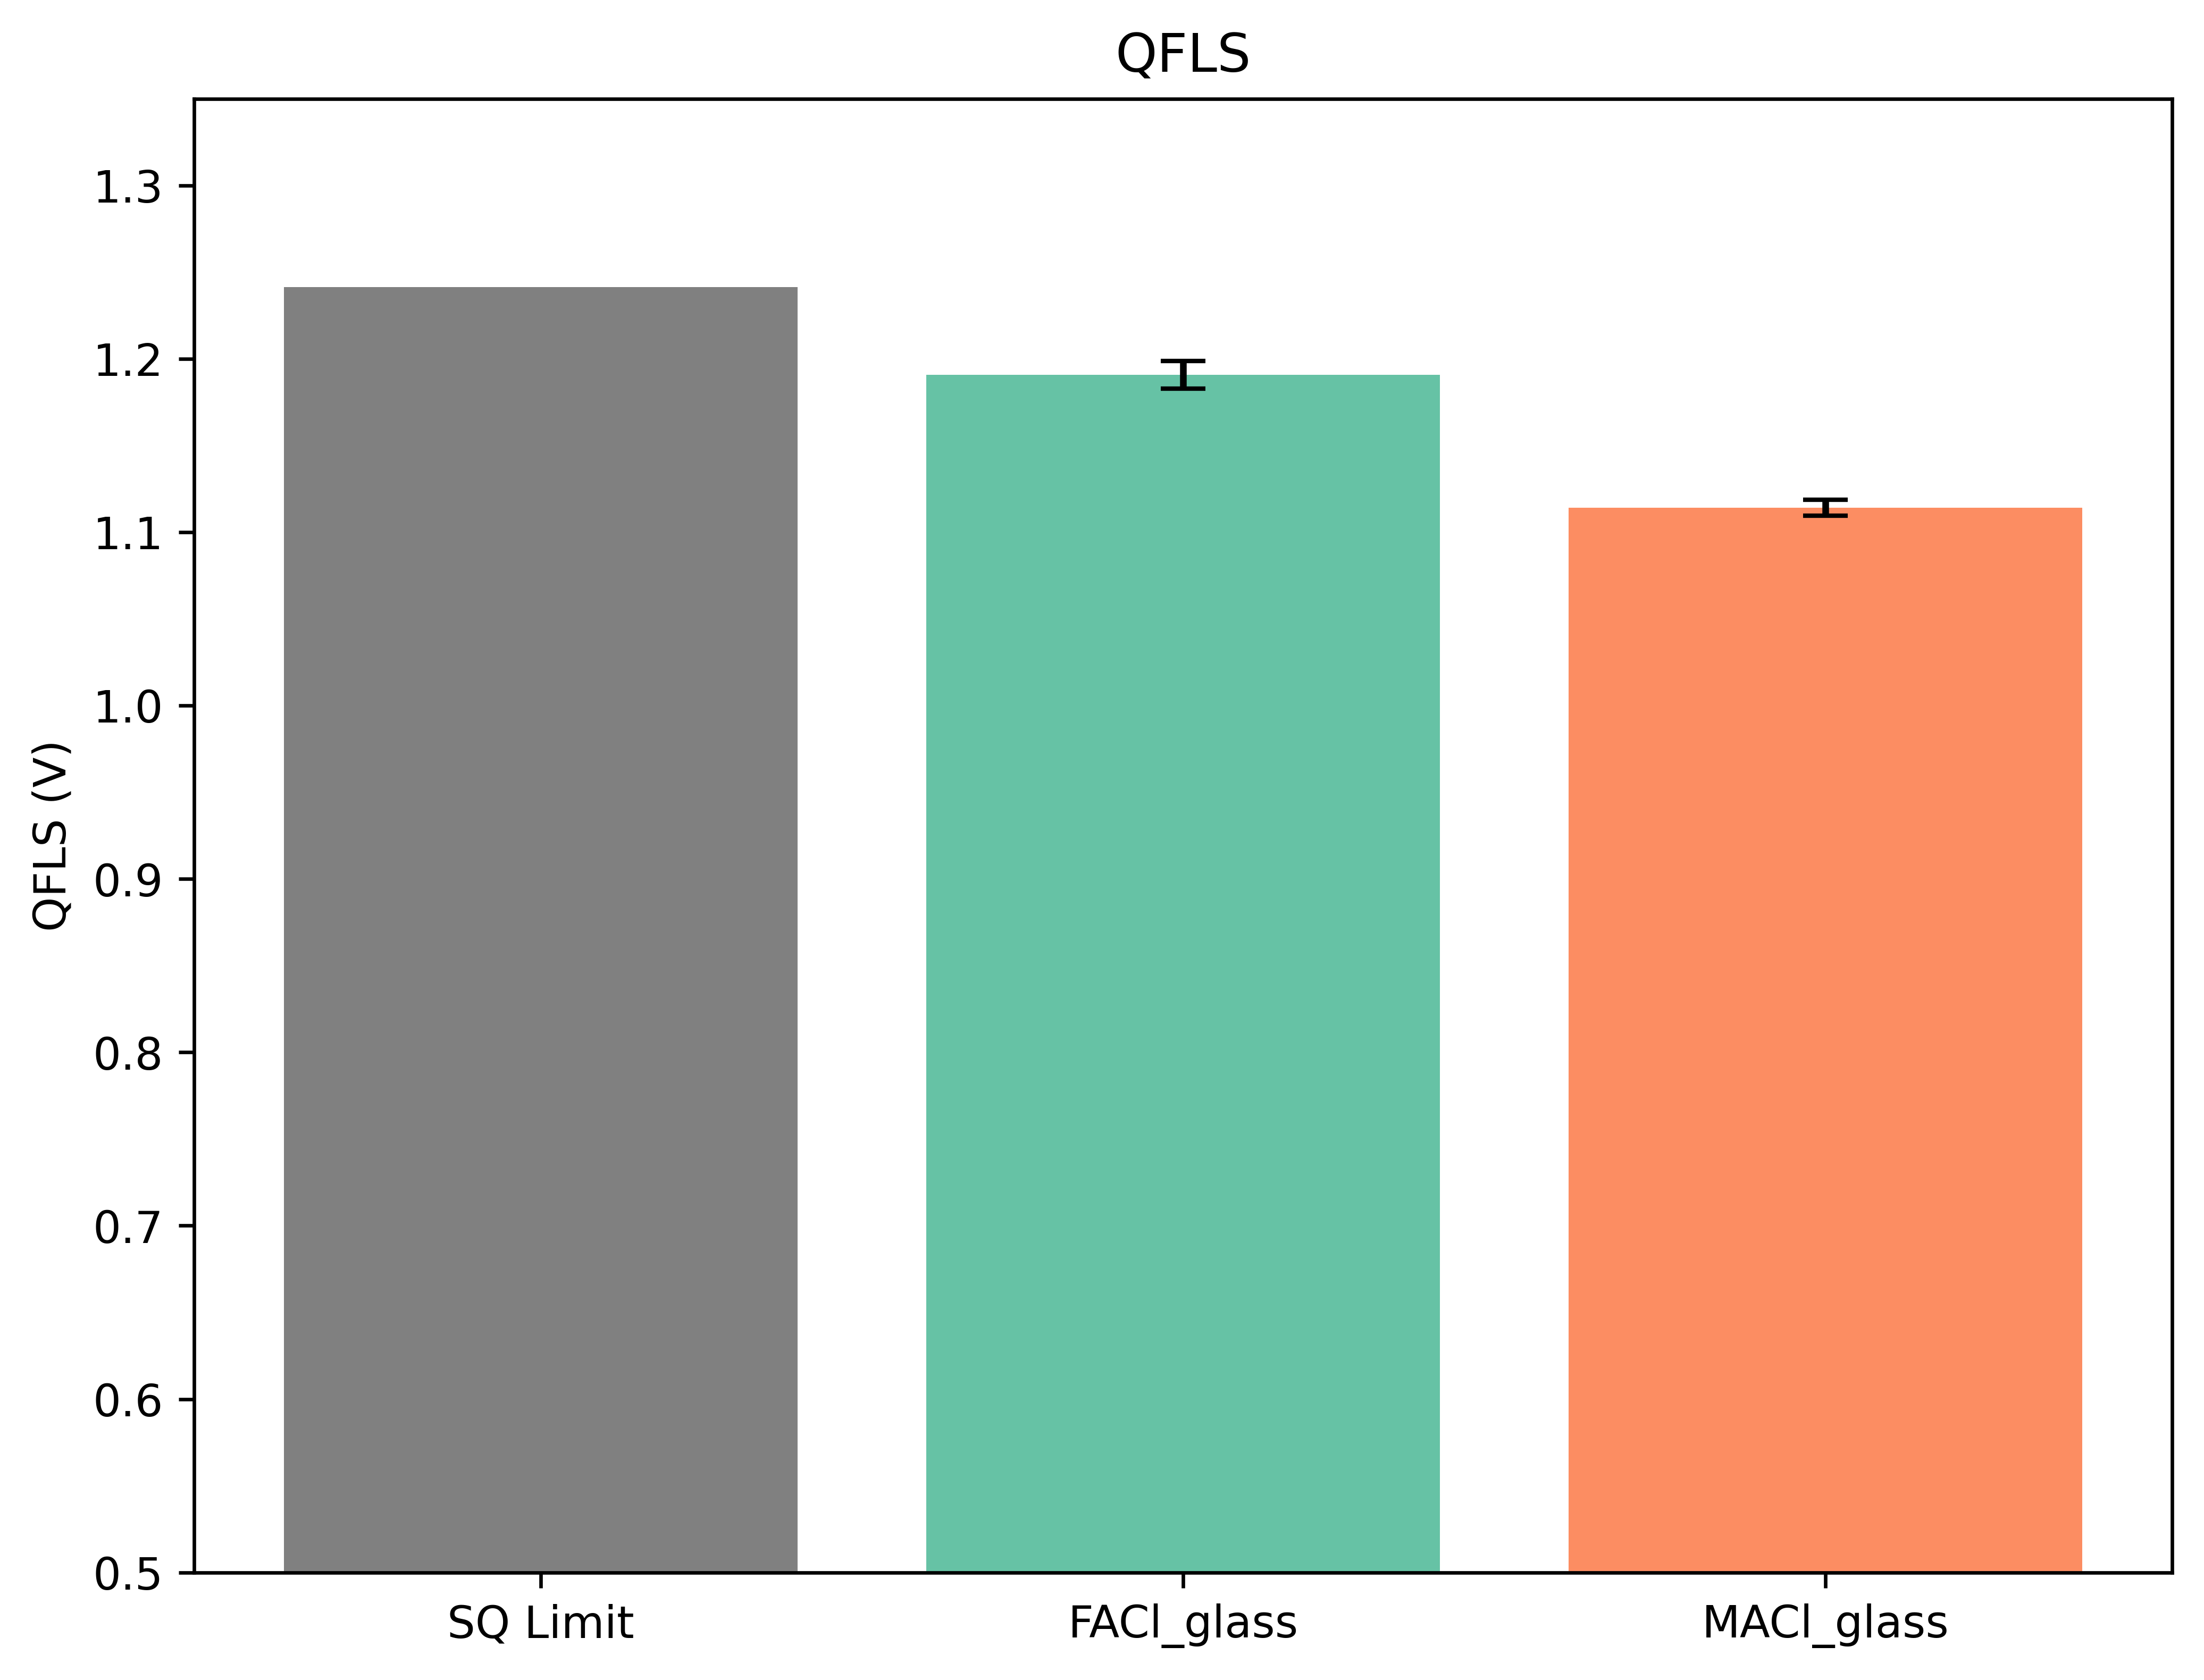

In [22]:
#Call the function, save by setting save=True
plot_qfls(save=True)